In [1]:
import pandas as pd
import numpy as np
from scipy.stats import f_oneway
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns

# Gene expression analysis

### Absolute expression

The below dataframe show the results from gene expression analysis; number or replicates each gene: 3

In [44]:
df_rel = pd.read_excel('Arabidopsis_Catalonia_DEF.xlsx', sheet_name = 'PCR_clean2')
i = df_rel[(df_rel['Accession'] == 'PO1')].index
df_rel = df_rel.drop(i)
df_rel.head()

,Target,Accession,Salinity,Heat treatment,Rep,Cq
0,AtACT2,A1,0,C,1,28.020994
1,AtACT2,A1,0,C,2,27.724578
2,AtACT2,A1,0,C,3,27.477329
3,AtACT2,A5,0,C,1,26.998562
4,AtACT2,A5,0,C,2,26.819575


<Figure size 1000x600 with 0 Axes>

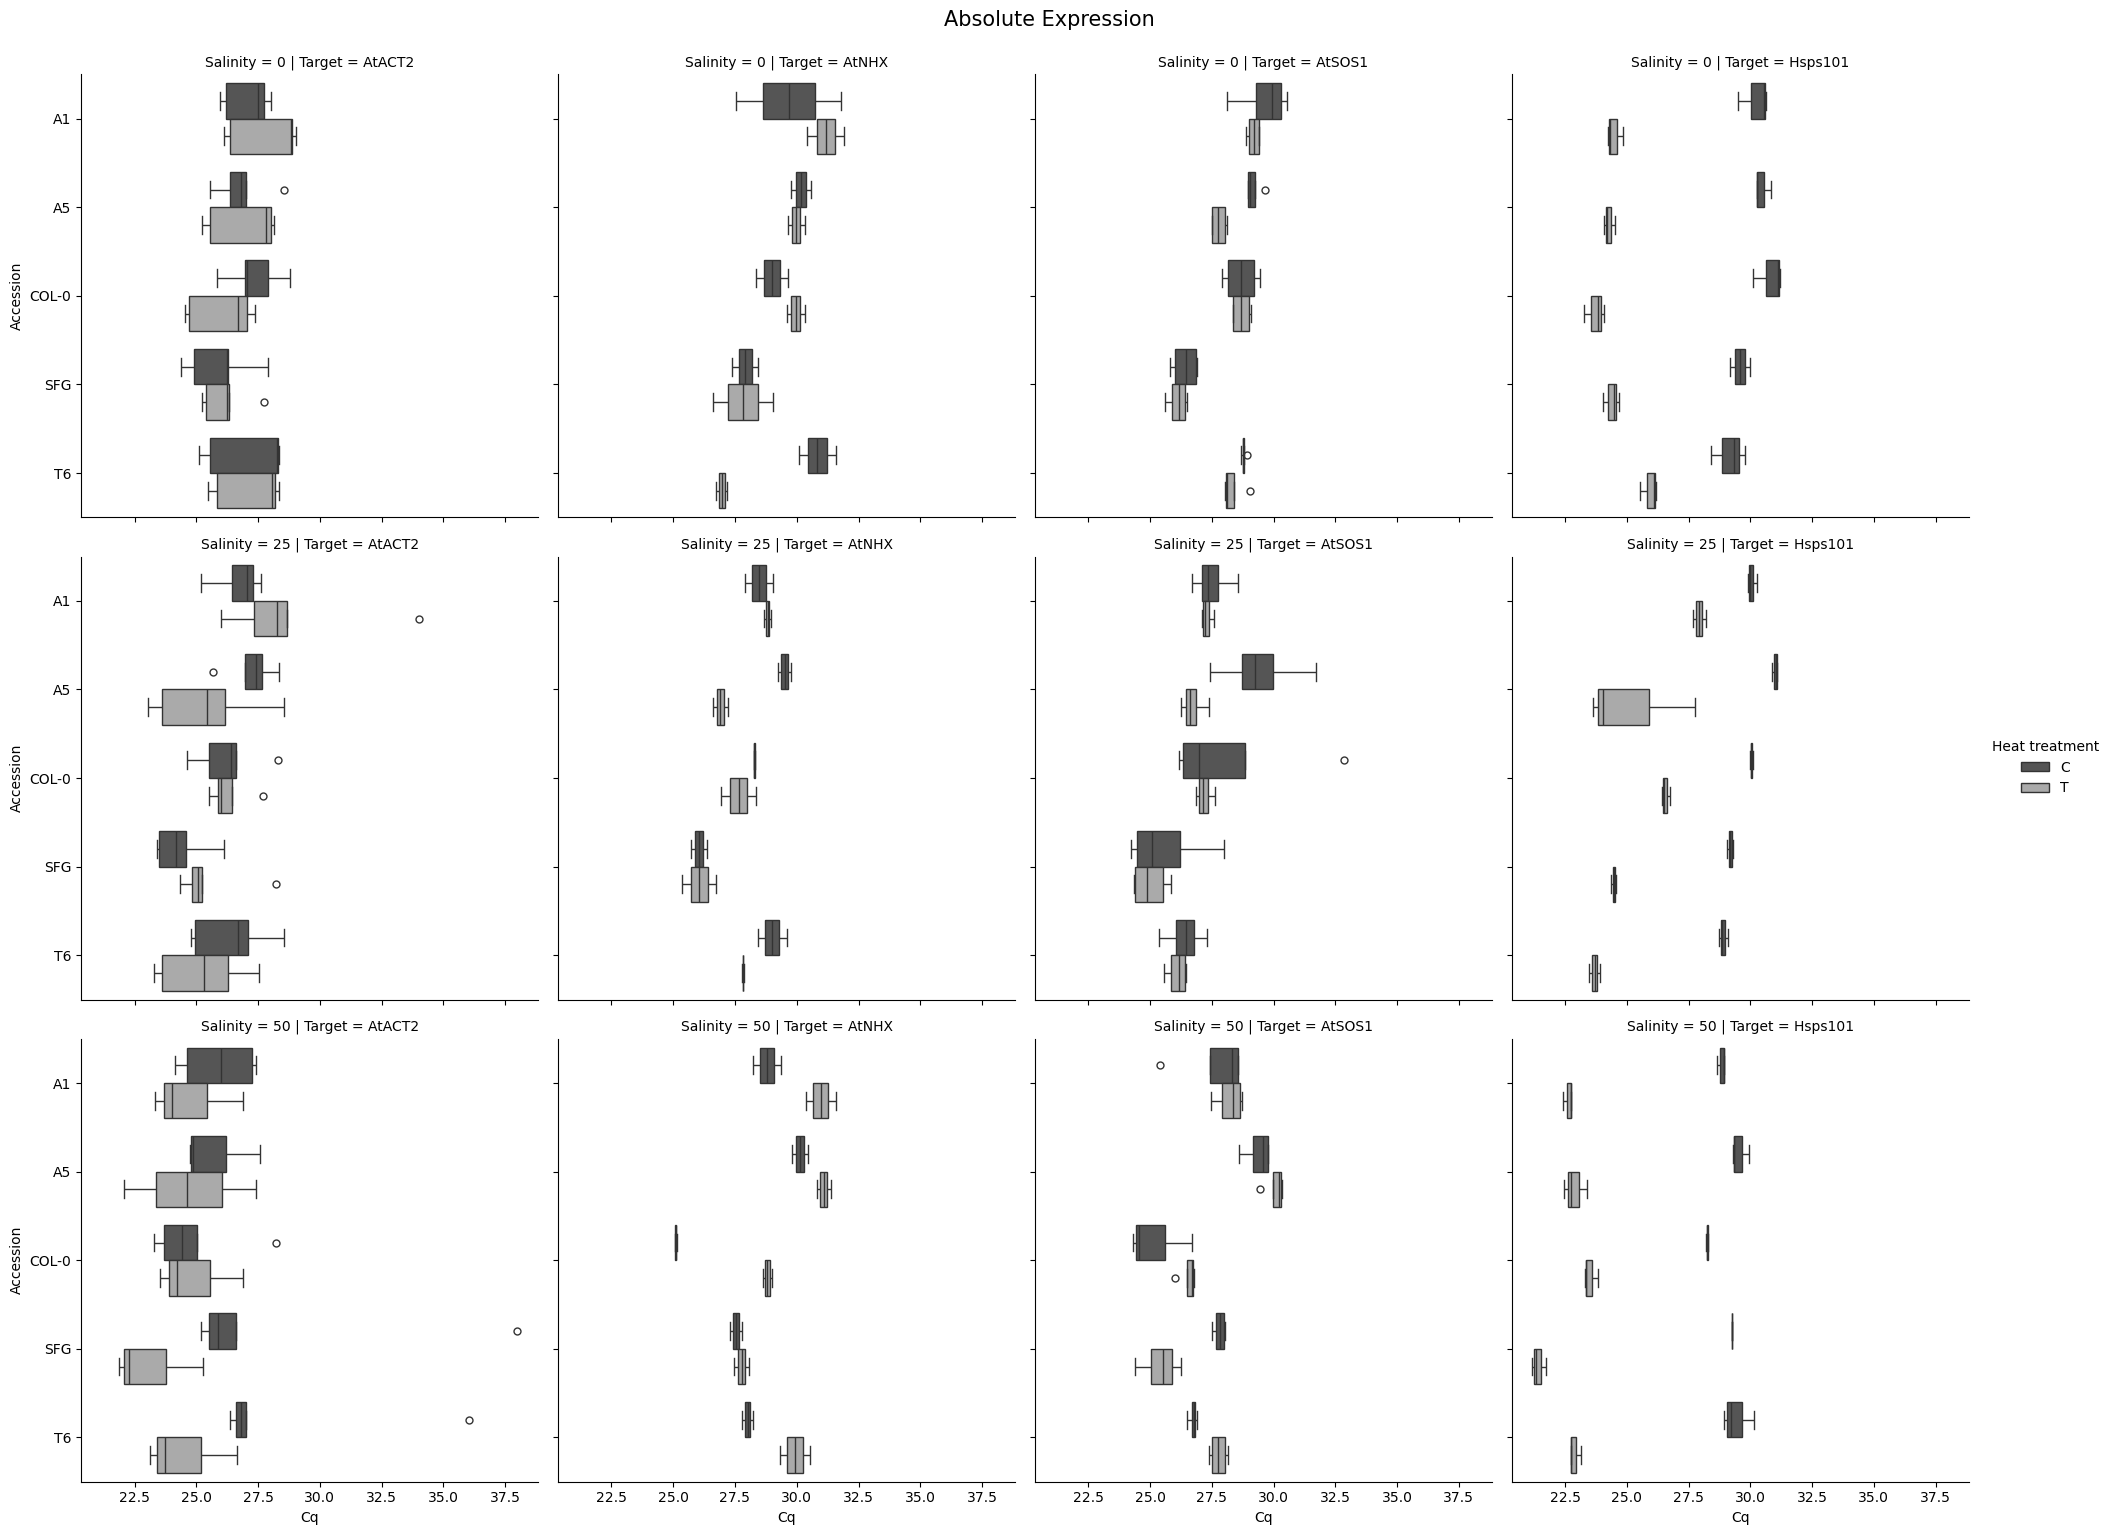

In [45]:
plt.figure(figsize=(10, 6))

g = sns.catplot(
    data=df_rel, 
    x='Cq', 
    y='Accession', 
    hue='Heat treatment', 
    col='Target', 
    row='Salinity',
    kind='box', 
    palette='grey', 
    height=5, 
    aspect=1
)
g.fig.suptitle('Absolute Expression', y=1.02, fontsize=15)
# Show the plot
plt.show()

## Delta Cq calculation

Here I calculate the Delta Cq by substracting the mean Cq values of the reference gene (Actine in this case) from the Cq of the target genes

In [49]:
df_reference = df_rel[(df_rel['Target'] == 'AtACT2')]
df_ref = df_reference.groupby(['Accession','Salinity','Heat treatment'])['Cq'].mean()
df_ref = df_ref.reset_index()
df_ref = df_ref.rename(columns={'Cq': 'Cq_mean_ref'})

In [50]:
df_target = df_rel[(df_rel['Target'] != 'AtACT2')]
df_merged = pd.merge(df_target, df_ref, on=['Accession', 'Salinity', 'Heat treatment'], how='left')
df_merged['delta Cq'] = df_merged['Cq'] - df_merged['Cq_mean_ref']
df_merged.to_excel('merged.xlsx', index = False)

## Relative expression calculation and plotting

Here I calculate the relative expression by substracting the delta Cd of the control treatment (no heat shock) from the treated with heat shock and using this value as the negative exponential of 2

In [53]:
control_df = df_merged[(df_merged['Heat treatment'] == 'C')]
treat_df = df_merged[(df_merged['Heat treatment'] == 'T')]
control_cq = control_df['delta Cq'].reset_index(drop=True)
treat_cq = treat_df['delta Cq'].reset_index(drop=True)
relative_cq = treat_cq - control_cq

Relative = pd.DataFrame({
    'Accession': treat_df['Accession'].reset_index(drop=True),
    'Salinity': treat_df['Salinity'].reset_index(drop=True),
    'Target': treat_df['Target'].reset_index(drop=True),
    'Rep': treat_df['Rep'].reset_index(drop=True),
    'delta Cq': relative_cq
})
Relative.head()

,Accession,Salinity,Target,Rep,delta Cq
0,A1,0,AtNHX,1,2.109261
1,A1,0,AtNHX,2,-0.642475
2,A5,0,AtNHX,1,-1.038062
3,A5,0,AtNHX,2,0.459985
4,COL-0,0,AtNHX,1,1.937886


In [54]:
Relative['Expression_Relative'] = 2 ** (-Relative['delta Cq'])
Relative.head()
Relative.to_excel('Relative expression.xlsx', index = False)

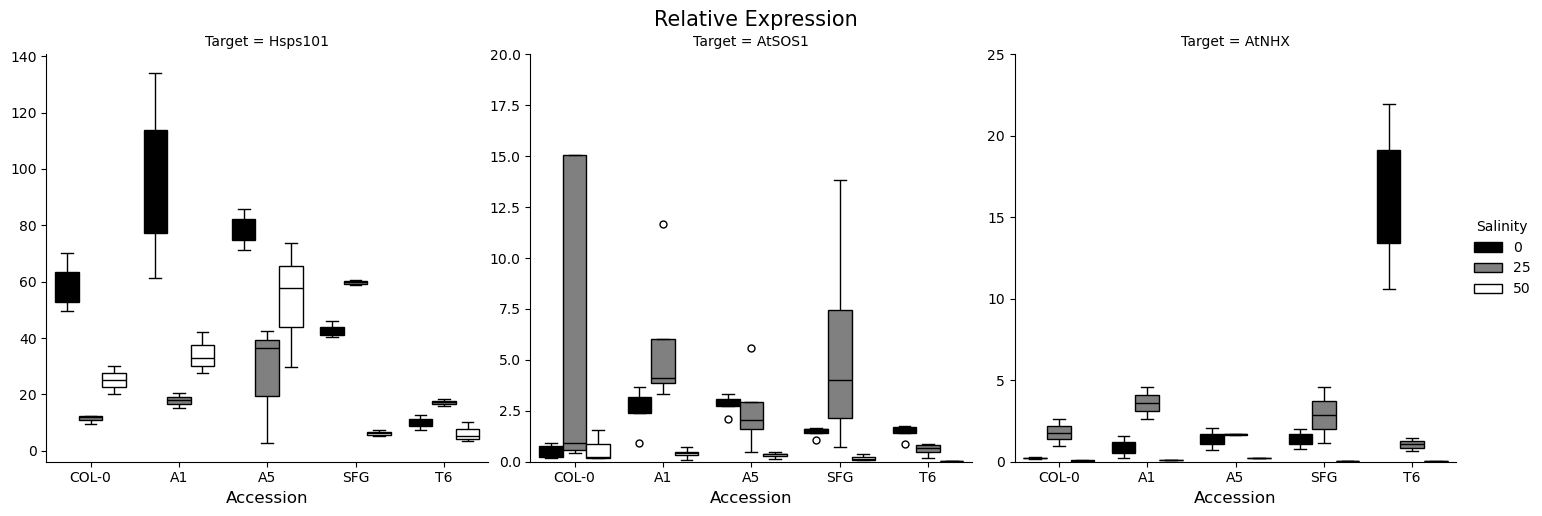

In [55]:
sample_order = ['COL-0', 'A1', 'A5','SFG','T6']
Targets = ['Hsps101', 'AtSOS1', 'AtNHX']
g = sns.catplot(
    data=Relative, 
    x='Accession', 
    y='Expression_Relative',
    col='Target',
    hue='Salinity',
    order=sample_order,
    col_order=Targets,
    kind='box', 
    palette='grey', 
    height=5, 
    aspect=1,
    #edgecolor='black',
    sharey=False,
)
g.fig.suptitle('Relative Expression', y=1.02, fontsize=15)
g.set_axis_labels('Accession','', fontsize = 12)
g.axes[0][1].set_ylim(0, 20)
g.axes[0][2].set_ylim(0, 25)
# Show the plot
plt.show()

## Statistical analysis for gene expression

## ANOVA and Tukey between accessions within salinity treatments

In [58]:
from scipy.stats import f_oneway
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [60]:
sal_groups = Relative['Salinity'].unique()
acc_groups = acc_groups = Relative['Accession'].unique()
tar_groups = Relative['Target'].unique()
results = []
posthoc_results = []
for sal in sal_groups:
    for tar in tar_groups:
        subset = Relative[(Relative['Salinity'] == sal) & (Relative['Target'] == tar)].dropna()
        anova_data = [subset[subset['Accession'] == group]['Expression_Relative'].dropna()
                      for group in acc_groups]
        result = stats.f_oneway(*anova_data)
        results.append({
            'Salinity': sal,
            'F-statistic': round(result.statistic, 3),
            'p-value': round(result.pvalue, 4),
            'Target': tar})
        tukey = pairwise_tukeyhsd(endog=subset['Expression_Relative'],
                                  groups=subset['Accession'],
                                  alpha=0.05)
        tukey_df = pd.DataFrame(data=tukey.summary().data[1:],
                                columns=tukey.summary().data[0])
        tukey_df['Salinity'] = sal
        tukey_df['Target'] = tar
        posthoc_results.append(tukey_df)


anova_table = pd.DataFrame(results)
anova_table.to_excel('ANOVA.xlsx', sheet_name = 'Gene expression', index = False)
posthoc_table = pd.concat(posthoc_results, ignore_index=True)
posthoc_table.to_excel('posthoc.xlsx', sheet_name = 'Gene expression', index = False)

In [64]:
import string

def letters_by_condition(df, alpha=0.05):
    results = {}
    
    df['p-adj'] = df['p-adj'].astype(float)
    sal_groups = df['Salinity'].unique()
    tar_groups = df['Target'].unique()

    for sal in sal_groups:
        for tar in tar_groups:
            sub_df = df[(df['Salinity'] == sal) & (df['Target'] == tar)]

            group1 = set(sub_df.group1.tolist())
            group2 = set(sub_df.group2.tolist())
            groupSet = group1 | group2
            groups = list(groupSet)

            letters_list = list(string.ascii_lowercase)[:len(groups)]
            cldgroups = letters_list.copy()

            cld = pd.DataFrame(list(zip(groups, letters_list, cldgroups)))
            cld[3] = ""

            for row in sub_df.itertuples():
                idx = row.Index
                if sub_df["p-adj"][idx] > alpha:
                    cld.iat[groups.index(sub_df["group1"][idx]), 2] += cld.iat[groups.index(sub_df["group2"][idx]), 1]
                    cld.iat[groups.index(sub_df["group2"][idx]), 2] += cld.iat[groups.index(sub_df["group1"][idx]), 1]
                else:
                    cld.iat[groups.index(sub_df["group1"][idx]), 3] += cld.iat[groups.index(sub_df["group2"][idx]), 1]
                    cld.iat[groups.index(sub_df["group2"][idx]), 3] += cld.iat[groups.index(sub_df["group1"][idx]), 1]

            cld[2] = cld[2].apply(lambda x: "".join(sorted(x)))
            cld[3] = cld[3].apply(lambda x: "".join(sorted(x)))
            cld.rename(columns={0: "groups"}, inplace=True)
            cld = cld.sort_values(cld.columns[2], key=lambda x: x.str.len())

            cld["labels"] = ""
            letters_seq = list(string.ascii_lowercase)
            unique = []

            for item in cld[2]:
                for fitem in cld["labels"].unique():
                    for c in range(len(fitem)):
                        if not set(unique).issuperset(set(fitem[c])):
                            unique.append(fitem[c])
                g = len(unique)

                for kitem in cld[1]:
                    if kitem in item:
                        if cld.loc[cld[1] == kitem, "labels"].iloc[0] == "":
                            cld.loc[cld[1] == kitem, "labels"] += letters_seq[g]

                        if kitem in ' '.join(cld[3][cld["labels"] == letters_seq[g]]):
                            g = len(unique) + 1

                        if len(set(cld.loc[cld[1] == kitem, "labels"].iloc[0])
                               .intersection(cld.loc[cld[2] == item, "labels"].iloc[0])) <= 0:
                            if letters_seq[g] not in cld.loc[cld[1] == kitem, "labels"].iloc[0]:
                                cld.loc[cld[1] == kitem, "labels"] += letters_seq[g]
                            if letters_seq[g] not in cld.loc[cld[2] == item, "labels"].iloc[0]:
                                cld.loc[cld[2] == item, "labels"] += letters_seq[g]

            cld = cld.sort_values("labels")
            cld.drop(columns=[1, 2, 3], inplace=True)
            label_dict = dict(zip(cld["groups"], cld["labels"]))
            results[(sal, tar)] = label_dict

    return results

In [70]:
letters = letters_by_condition(posthoc_table, alpha=0.05)
letters_table = pd.DataFrame(letters)
letters_table.to_excel('letters.xlsx', sheet_name = 'Gene expression')
letters_table

0                    25                   50               
      AtNHX AtSOS1 Hsps101 AtNHX AtSOS1 Hsps101 AtNHX AtSOS1 Hsps101
T6        a     ab       a     a      a       b     b      a       b
A1        b      b       b     a      a       b     c      a      ab
A5        b      b      bc     a      a      ab     a      a       a
COL-0     b      a      bc     a      a       b     c      a      ab
SFG       b     ab      ac     a      a       a     b      a       b

The results from the analysis are saved on excel file; the letters on the plot will be put manually with another sofrware

### Let's create some variable to save the next dataframes in the already created excel files

In [92]:
path_1 = r'ANOVA.xlsx'
path_2 = r'posthoc.xlsx'
path_3 = r'letters.xlsx'

## ANOVA and Tukey between salinity treatments within accessions

In [96]:
sal_groups = Relative['Salinity'].unique()
acc_groups = acc_groups = Relative['Accession'].unique()
tar_groups = Relative['Target'].unique()
results = []
posthoc_results = []
for acc in acc_groups:
    for tar in tar_groups:
        subset = Relative[(Relative['Accession'] == acc) & (Relative['Target'] == tar)].dropna()
        anova_data = [subset[subset['Salinity'] == group]['Expression_Relative'].dropna()
                      for group in sal_groups]
        result = stats.f_oneway(*anova_data)
        results.append({
            'Accession': acc,
            'F-statistic': round(result.statistic, 3),
            'p-value': round(result.pvalue, 4),
            'Target': tar})
        tukey = pairwise_tukeyhsd(endog=subset['Expression_Relative'],
                                  groups=subset['Salinity'],
                                  alpha=0.05)
        tukey_df = pd.DataFrame(data=tukey.summary().data[1:],
                                columns=tukey.summary().data[0])
        tukey_df['Accession'] = acc
        tukey_df['Target'] = tar
        posthoc_results.append(tukey_df)


anova_table = pd.DataFrame(results)
with pd.ExcelWriter(path_1, engine='openpyxl', mode='a') as writer:
    anova_table.to_excel(writer, sheet_name='Gene expression (salinity)', index=False)
posthoc_table = pd.concat(posthoc_results, ignore_index=True)
with pd.ExcelWriter(path_2, engine='openpyxl', mode='a') as writer:
    posthoc_table.to_excel(writer, sheet_name='Gene expression (salinity)', index=False)

In [122]:
def letters(df, alpha=0.05):
    results = {}
    
    df['p-adj'] = df['p-adj'].astype(float)
    acc_groups = df['Accession'].unique()
    tar_groups = df['Target'].unique()

    for acc in acc_groups:
        for tar in tar_groups:
            sub_df = df[(df['Accession'] == acc) & (df['Target'] == tar)]

            group1 = set(sub_df.group1.tolist())
            group2 = set(sub_df.group2.tolist())
            groupSet = group1 | group2
            groups = list(groupSet)

            letters_list = list(string.ascii_lowercase)[:len(groups)]
            cldgroups = letters_list.copy()

            cld = pd.DataFrame(list(zip(groups, letters_list, cldgroups)))
            cld[3] = ""

            for row in sub_df.itertuples():
                idx = row.Index
                if sub_df["p-adj"][idx] > alpha:
                    cld.iat[groups.index(sub_df["group1"][idx]), 2] += cld.iat[groups.index(sub_df["group2"][idx]), 1]
                    cld.iat[groups.index(sub_df["group2"][idx]), 2] += cld.iat[groups.index(sub_df["group1"][idx]), 1]
                else:
                    cld.iat[groups.index(sub_df["group1"][idx]), 3] += cld.iat[groups.index(sub_df["group2"][idx]), 1]
                    cld.iat[groups.index(sub_df["group2"][idx]), 3] += cld.iat[groups.index(sub_df["group1"][idx]), 1]

            cld[2] = cld[2].apply(lambda x: "".join(sorted(x)))
            cld[3] = cld[3].apply(lambda x: "".join(sorted(x)))
            cld.rename(columns={0: "groups"}, inplace=True)
            cld = cld.sort_values(cld.columns[2], key=lambda x: x.str.len())

            cld["labels"] = ""
            letters_seq = list(string.ascii_lowercase)
            unique = []

            for item in cld[2]:
                for fitem in cld["labels"].unique():
                    for c in range(len(fitem)):
                        if not set(unique).issuperset(set(fitem[c])):
                            unique.append(fitem[c])
                g = len(unique)

                for kitem in cld[1]:
                    if kitem in item:
                        if cld.loc[cld[1] == kitem, "labels"].iloc[0] == "":
                            cld.loc[cld[1] == kitem, "labels"] += letters_seq[g]

                        if kitem in ' '.join(cld[3][cld["labels"] == letters_seq[g]]):
                            g = len(unique) + 1

                        if len(set(cld.loc[cld[1] == kitem, "labels"].iloc[0])
                               .intersection(cld.loc[cld[2] == item, "labels"].iloc[0])) <= 0:
                            if letters_seq[g] not in cld.loc[cld[1] == kitem, "labels"].iloc[0]:
                                cld.loc[cld[1] == kitem, "labels"] += letters_seq[g]
                            if letters_seq[g] not in cld.loc[cld[2] == item, "labels"].iloc[0]:
                                cld.loc[cld[2] == item, "labels"] += letters_seq[g]

            cld = cld.sort_values("labels")
            cld.drop(columns=[1, 2, 3], inplace=True)
            label_dict = dict(zip(cld["groups"], cld["labels"]))
            results[(acc, tar)] = label_dict

    return results

In [124]:
letters = letters(posthoc_table, alpha=0.05)
letters_table = pd.DataFrame(letters)
with pd.ExcelWriter(path_3, engine='openpyxl', mode='a') as writer:
    letters_table.to_excel(writer, sheet_name='Gene expression (salinity)')

# Chlorophyll Fluorescence analysis

## Kautsky Kinetic

In [15]:
df = pd.read_excel('FLUORCAM.xlsx', sheet_name = 'dataframe_final')
df = df.rename(columns={"Salt mM": "Salinity (mM)"})
df.head()

,Salinity (mM),Accession,Heat,Treatment,Rep,Size [pixels],Fo,Fo_gauss,Fo_median,Fm,...,qL_D1,Rfd_L1,NPQt,qIt,qEt,qE,NPQ,qI_das,qI_las,qI_tot
0,0,A1,C,Control,1,207,11712,11712,7951,47962,...,103,113,1.711090,0.811955,0.899135,0.047489,0.209604,0.08,0.164497,0.244497
1,0,A1,C,Control,2,717,8552,8552,6150,46686,...,105,192,0.830680,0.237638,0.593041,0.043126,0.174250,0.02,0.136623,0.156623
2,0,A1,C,Control,3,408,8703,8703,5462,42961,...,104,179,1.098832,0.469330,0.629502,0.014768,0.203895,0.04,0.187524,0.227524
3,0,A1,C,Control,4,445,8736,8736,5453,49077,...,106,209,0.758736,0.279657,0.479079,0.008116,0.225516,0.01,0.207139,0.217139
4,0,A1,C,Control,5,488,9072,9072,6011,43168,...,105,157,1.244618,0.468319,0.776299,0.037355,0.176176,0.05,0.141630,0.191630


In [19]:
control_values = df[df['Treatment'] == 'Control'].set_index(['Salinity (mM)','Accession', 'Rep'])['Fm'].to_dict()

In [21]:
df['Fm_control'] = df.apply(lambda row: control_values.get((row['Salinity (mM)'], row['Accession'], row['Rep']), None), axis=1)
df['qI'] = (df['Fm_control'] - df['Fm_L1']) / df['Fm_D1']
df.head()

,Salinity (mM),Accession,Heat,Treatment,Rep,Size [pixels],Fo,Fo_gauss,Fo_median,Fm,...,NPQt,qIt,qEt,qE,NPQ,qI_das,qI_las,qI_tot,Fm_control,qI
0,0,A1,C,Control,1,207,11712,11712,7951,47962,...,1.711090,0.811955,0.899135,0.047489,0.209604,0.08,0.164497,0.244497,47962,0.200101
1,0,A1,C,Control,2,717,8552,8552,6150,46686,...,0.830680,0.237638,0.593041,0.043126,0.174250,0.02,0.136623,0.156623,46686,0.174250
2,0,A1,C,Control,3,408,8703,8703,5462,42961,...,1.098832,0.469330,0.629502,0.014768,0.203895,0.04,0.187524,0.227524,42961,0.200928
3,0,A1,C,Control,4,445,8736,8736,5453,49077,...,0.758736,0.279657,0.479079,0.008116,0.225516,0.01,0.207139,0.217139,49077,0.223700
4,0,A1,C,Control,5,488,9072,9072,6011,43168,...,1.244618,0.468319,0.776299,0.037355,0.176176,0.05,0.141630,0.191630,43168,0.169832


In [23]:
def Get_results(Parameter, param):
    sample_order = ['Col-0', 'A1', 'A5', 'SFG', 'T6']
    hue_order = ['Control', 'Heat', 'Recovery']
    
    # Increase figure size: height = height of each facet, aspect = width/height ratio
    g = sns.catplot(
        x='Accession', y=Parameter, data=df, hue='Treatment', col='Salinity (mM)',
        order=sample_order, hue_order=hue_order,
        kind='box', linewidth=1, palette='dark:.9', legend='auto',
        height=5, aspect=1
    )
    
    g._legend.set_bbox_to_anchor((1, 0.9))
    g._legend.set_loc('upper right')
    g.set_axis_labels("Accession", Parameter)
    g.set_xlabels("Accession", fontsize=13)
    g.set_ylabels(param, fontsize=13)
    for ax in g.axes.flatten():
        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

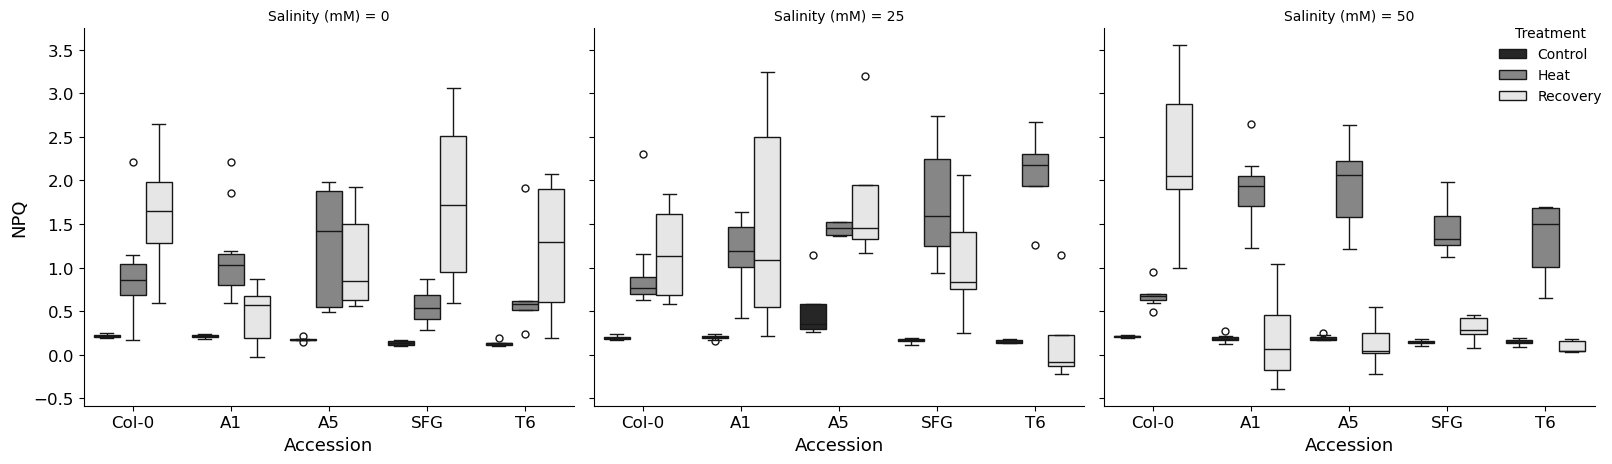

In [27]:
Get_results('NPQ', 'NPQ')

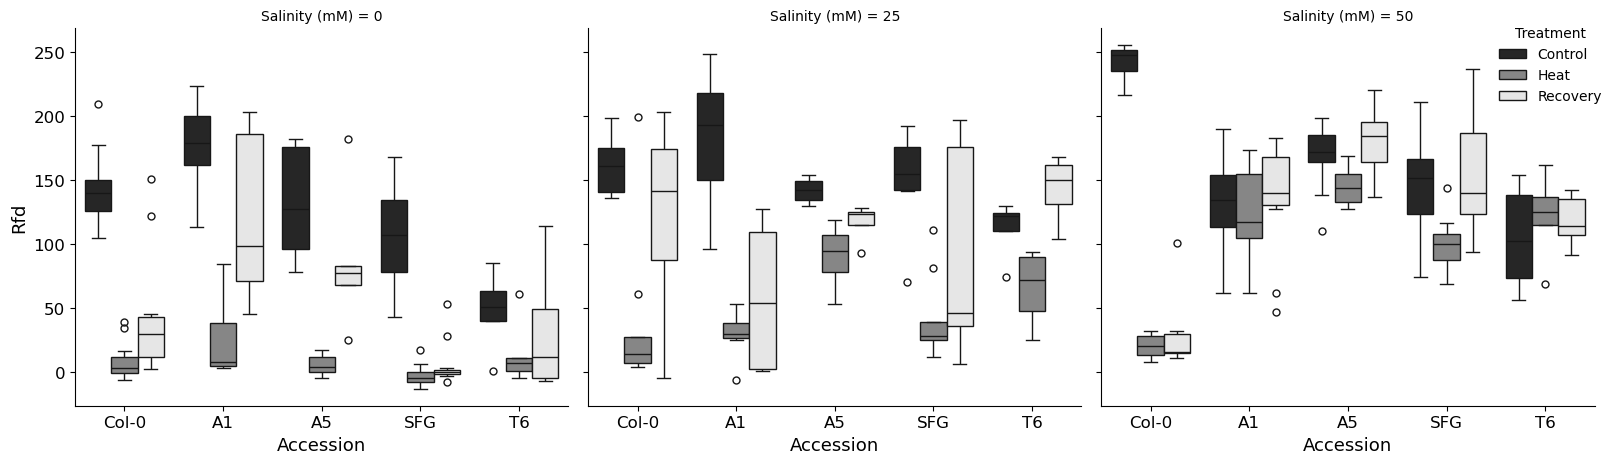

In [29]:
Get_results('Rfd_L1', 'Rfd')

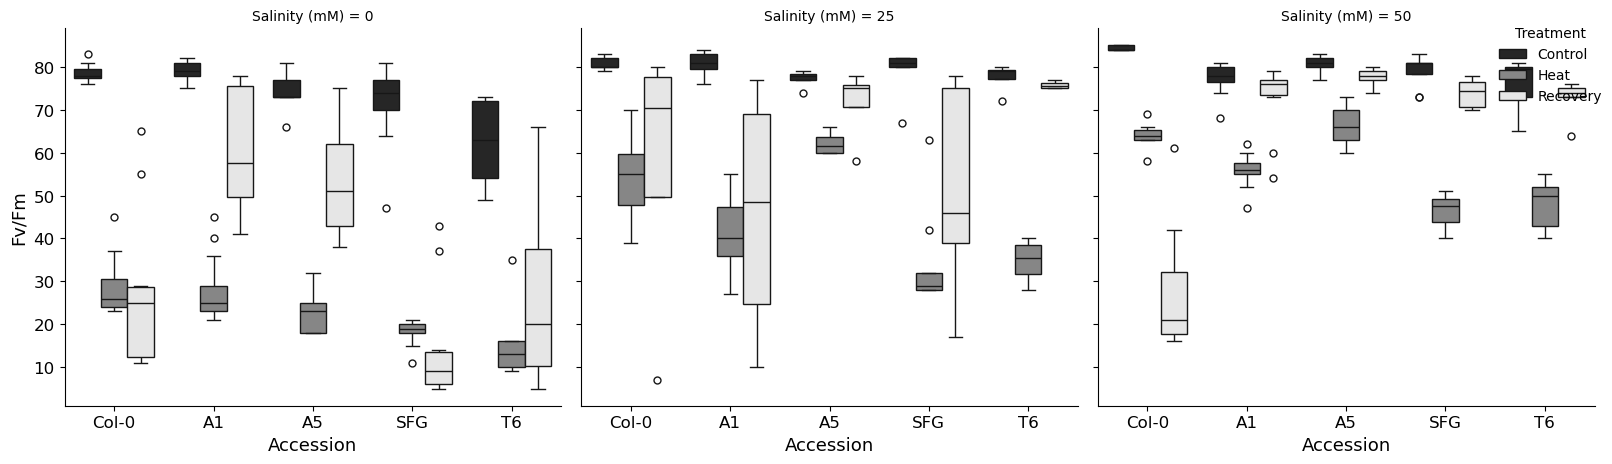

In [31]:
Get_results('QY_max', 'Fv/Fm')

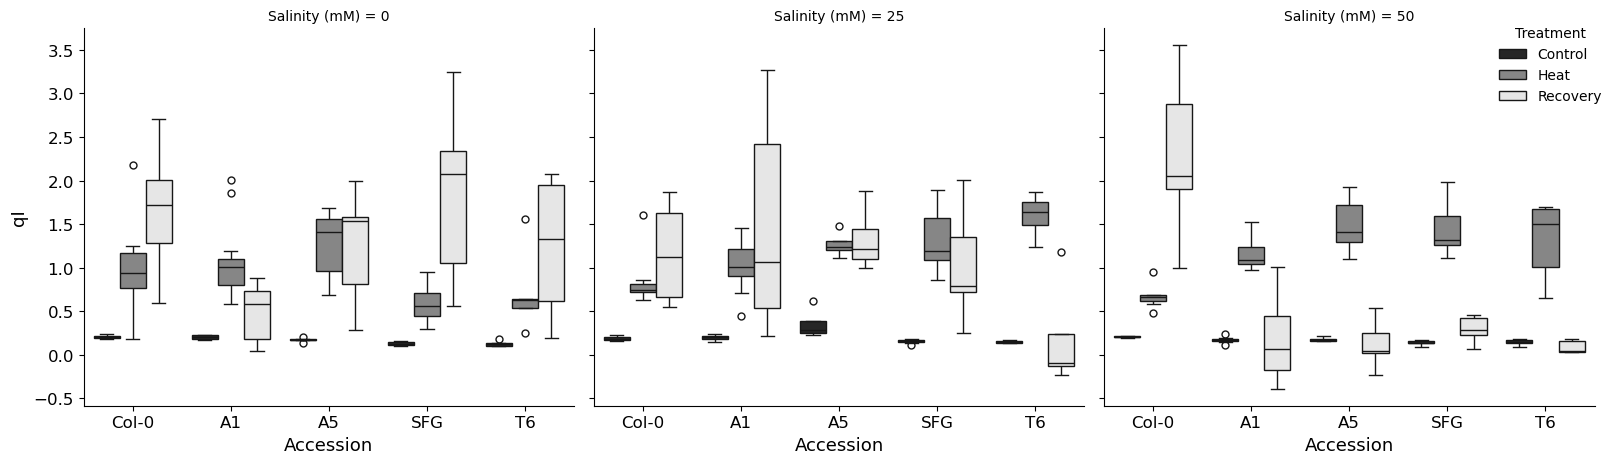

In [32]:
Get_results('qI', 'qI')

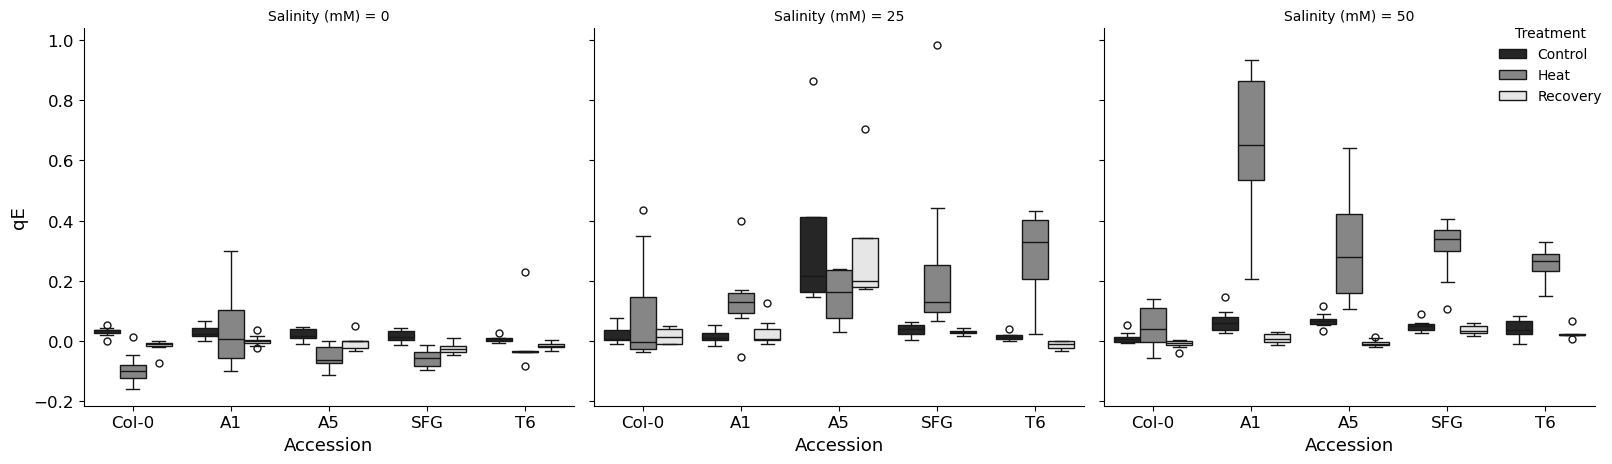

In [33]:
Get_results('qE', 'qE')

In [ ]:
sal_groups = Relative['Salinity'].unique()
acc_groups = acc_groups = Relative['Accession'].unique()
tar_groups = Relative['Target'].unique()
results = []
posthoc_results = []
for acc in acc_groups:
    for tar in tar_groups:
        subset = Relative[(Relative['Accession'] == acc) & (Relative['Target'] == tar)].dropna()
        anova_data = [subset[subset['Salinity'] == group]['Expression_Relative'].dropna()
                      for group in sal_groups]
        result = stats.f_oneway(*anova_data)
        results.append({
            'Accession': acc,
            'F-statistic': round(result.statistic, 3),
            'p-value': round(result.pvalue, 4),
            'Target': tar})
        tukey = pairwise_tukeyhsd(endog=subset['Expression_Relative'],
                                  groups=subset['Salinity'],
                                  alpha=0.05)
        tukey_df = pd.DataFrame(data=tukey.summary().data[1:],
                                columns=tukey.summary().data[0])
        tukey_df['Accession'] = acc
        tukey_df['Target'] = tar
        posthoc_results.append(tukey_df)


anova_table = pd.DataFrame(results)
posthoc_table = pd.concat(posthoc_results, ignore_index=True)

#### I create a function that calculate everything and export the results in excel sheets

In [213]:
def Get_statistic(Parameter):
    salt_levels = df['Salinity (mM)'].unique()
    accessions = df['Accession'].unique()
    heat_levels = df['Treatment'].unique()
    acc_tukey_results = []
    acc_kk_results = []
    h_tukey_results = []
    h_kk_results = []
    for salt in salt_levels:
        df_salt = df[df['Salinity (mM)'] == salt]
        for accession in accessions:
            df_accession = df_salt[df_salt['Accession'] == accession]
            heat_groups = df_accession['Treatment'].unique()
            anova_acc_kk_data = [df_accession[df_accession['Treatment'] == group][Parameter].dropna()
                             for group in heat_groups]
            kk_result = stats.f_oneway(*anova_acc_kk_data)
            acc_kk_results.append({
                'Accession': accession,
                'F-statistic': round(kk_result.statistic, 3),
                'p-value': round(kk_result.pvalue, 4),
                'Salinity': salt})
            posthoc = pairwise_tukeyhsd(df_accession[Parameter], df_accession['Treatment'], alpha=0.05)           
            posthoc_df = pd.DataFrame(posthoc.summary().data[1:], columns=posthoc.summary().data[0])
            tukey_acc_df = pd.DataFrame(posthoc.summary().data[1:], columns=posthoc.summary().data[0])
            tukey_acc_df['Accession'] = accession
            tukey_acc_df['Salinity (mM)'] = salt
            acc_tukey_results.append(tukey_acc_df)
    anova_acc_kk_table = pd.DataFrame(acc_kk_results)
    accession_table = pd.concat(acc_tukey_results, ignore_index=True)
    for salt in salt_levels:
        df_salt = df[df['Salinity (mM)'] == salt]
        for heat_level in heat_levels:
            df_heat = df_salt[df_salt['Treatment'] == heat_level]
            accession_groups = df_heat['Accession'].unique()
            anova_h_kk_data = [df_heat[df_heat['Accession'] == group][Parameter].dropna()
                             for group in accession_groups]
            h_kk_result = stats.f_oneway(*anova_h_kk_data)
            h_kk_results.append({
                'Treatment': heat_level,
                'F-statistic': round(h_kk_result.statistic, 3),
                'p-value': round(h_kk_result.pvalue, 4),
                'Salinity': salt})
            posthoc = pairwise_tukeyhsd(df_heat[Parameter], df_heat['Accession'], alpha=0.05)           
            posthoc_df = pd.DataFrame(posthoc.summary().data[1:], columns=posthoc.summary().data[0])
            tukey_h_df = pd.DataFrame(posthoc.summary().data[1:], columns=posthoc.summary().data[0])
            tukey_h_df['Treatment'] = heat_level
            tukey_h_df['Salinity (mM)'] = salt
            h_tukey_results.append(tukey_h_df)
    anova_h_kk_table = pd.DataFrame(h_kk_results)
    heat_table = pd.concat(h_tukey_results, ignore_index=True)
    anova_acc_kk_table
    with pd.ExcelWriter(path_1, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
        anova_acc_kk_table.to_excel(writer, sheet_name= f'{Parameter} accession', index=False)
    with pd.ExcelWriter(path_2, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
        accession_table.to_excel(writer, sheet_name= f'{Parameter} accession',index=False)
    with pd.ExcelWriter(path_1, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
        anova_h_kk_table.to_excel(writer, sheet_name= f'{Parameter} heat',index=False)
    with pd.ExcelWriter(path_2, engine='openpyxl', mode='a',if_sheet_exists='replace') as writer:
        heat_table.to_excel(writer, sheet_name= f'{Parameter} heat', index=False)

    alpha=0.05
    
    results_1 = {}
    
    accession_table['p-adj'] = accession_table['p-adj'].astype(float)
    acc_groups = df['Accession'].unique()
    sal_groups = df['Salinity (mM)'].unique()

    for acc in acc_groups:
        for sal in sal_groups:
            sub_df = accession_table[(accession_table['Accession'] == acc) & (accession_table['Salinity (mM)'] == sal)]

            group1 = set(sub_df.group1.tolist())
            group2 = set(sub_df.group2.tolist())
            groupSet = group1 | group2
            groups = list(groupSet)

            letters_list = list(string.ascii_lowercase)[:len(groups)]
            cldgroups = letters_list.copy()

            cld = pd.DataFrame(list(zip(groups, letters_list, cldgroups)))
            cld[3] = ""

            for row in sub_df.itertuples():
                idx = row.Index
                if sub_df["p-adj"][idx] > alpha:
                    cld.iat[groups.index(sub_df["group1"][idx]), 2] += cld.iat[groups.index(sub_df["group2"][idx]), 1]
                    cld.iat[groups.index(sub_df["group2"][idx]), 2] += cld.iat[groups.index(sub_df["group1"][idx]), 1]
                else:
                    cld.iat[groups.index(sub_df["group1"][idx]), 3] += cld.iat[groups.index(sub_df["group2"][idx]), 1]
                    cld.iat[groups.index(sub_df["group2"][idx]), 3] += cld.iat[groups.index(sub_df["group1"][idx]), 1]

            cld[2] = cld[2].apply(lambda x: "".join(sorted(x)))
            cld[3] = cld[3].apply(lambda x: "".join(sorted(x)))
            cld.rename(columns={0: "groups"}, inplace=True)
            cld = cld.sort_values(cld.columns[2], key=lambda x: x.str.len())

            cld["labels"] = ""
            letters_seq = list(string.ascii_lowercase)
            unique = []

            for item in cld[2]:
                for fitem in cld["labels"].unique():
                    for c in range(len(fitem)):
                        if not set(unique).issuperset(set(fitem[c])):
                            unique.append(fitem[c])
                g = len(unique)

                for kitem in cld[1]:
                    if kitem in item:
                        if cld.loc[cld[1] == kitem, "labels"].iloc[0] == "":
                            cld.loc[cld[1] == kitem, "labels"] += letters_seq[g]

                        if kitem in ' '.join(cld[3][cld["labels"] == letters_seq[g]]):
                            g = len(unique) + 1

                        if len(set(cld.loc[cld[1] == kitem, "labels"].iloc[0])
                               .intersection(cld.loc[cld[2] == item, "labels"].iloc[0])) <= 0:
                            if letters_seq[g] not in cld.loc[cld[1] == kitem, "labels"].iloc[0]:
                                cld.loc[cld[1] == kitem, "labels"] += letters_seq[g]
                            if letters_seq[g] not in cld.loc[cld[2] == item, "labels"].iloc[0]:
                                cld.loc[cld[2] == item, "labels"] += letters_seq[g]

            cld = cld.sort_values("labels")
            cld.drop(columns=[1, 2, 3], inplace=True)
            label_dict_1 = dict(zip(cld["groups"], cld["labels"]))
            results_1[(acc, sal)] = label_dict_1
            letters_1 = pd.DataFrame(results_1)
            with pd.ExcelWriter(path_3, engine='openpyxl', mode='a',if_sheet_exists='replace') as writer:
                letters_1.to_excel(writer, sheet_name= f'{Parameter} accession')


    results_2 = {}
    
    heat_table['p-adj'] = heat_table['p-adj'].astype(float)
    heat_groups = df['Treatment'].unique()
    sal_groups = df['Salinity (mM)'].unique()

    for heat in heat_groups:
        for sal in sal_groups:
            sub_df = heat_table[(heat_table['Treatment'] == heat) & (heat_table['Salinity (mM)'] == sal)]

            group1 = set(sub_df.group1.tolist())
            group2 = set(sub_df.group2.tolist())
            groupSet = group1 | group2
            groups = list(groupSet)

            letters_list = list(string.ascii_lowercase)[:len(groups)]
            cldgroups = letters_list.copy()

            cld = pd.DataFrame(list(zip(groups, letters_list, cldgroups)))
            cld[3] = ""

            for row in sub_df.itertuples():
                idx = row.Index
                if sub_df["p-adj"][idx] > alpha:
                    cld.iat[groups.index(sub_df["group1"][idx]), 2] += cld.iat[groups.index(sub_df["group2"][idx]), 1]
                    cld.iat[groups.index(sub_df["group2"][idx]), 2] += cld.iat[groups.index(sub_df["group1"][idx]), 1]
                else:
                    cld.iat[groups.index(sub_df["group1"][idx]), 3] += cld.iat[groups.index(sub_df["group2"][idx]), 1]
                    cld.iat[groups.index(sub_df["group2"][idx]), 3] += cld.iat[groups.index(sub_df["group1"][idx]), 1]

            cld[2] = cld[2].apply(lambda x: "".join(sorted(x)))
            cld[3] = cld[3].apply(lambda x: "".join(sorted(x)))
            cld.rename(columns={0: "groups"}, inplace=True)
            cld = cld.sort_values(cld.columns[2], key=lambda x: x.str.len())

            cld["labels"] = ""
            letters_seq = list(string.ascii_lowercase)
            unique = []

            for item in cld[2]:
                for fitem in cld["labels"].unique():
                    for c in range(len(fitem)):
                        if not set(unique).issuperset(set(fitem[c])):
                            unique.append(fitem[c])
                g = len(unique)

                for kitem in cld[1]:
                    if kitem in item:
                        if cld.loc[cld[1] == kitem, "labels"].iloc[0] == "":
                            cld.loc[cld[1] == kitem, "labels"] += letters_seq[g]

                        if kitem in ' '.join(cld[3][cld["labels"] == letters_seq[g]]):
                            g = len(unique) + 1

                        if len(set(cld.loc[cld[1] == kitem, "labels"].iloc[0])
                               .intersection(cld.loc[cld[2] == item, "labels"].iloc[0])) <= 0:
                            if letters_seq[g] not in cld.loc[cld[1] == kitem, "labels"].iloc[0]:
                                cld.loc[cld[1] == kitem, "labels"] += letters_seq[g]
                            if letters_seq[g] not in cld.loc[cld[2] == item, "labels"].iloc[0]:
                                cld.loc[cld[2] == item, "labels"] += letters_seq[g]

            cld = cld.sort_values("labels")
            cld.drop(columns=[1, 2, 3], inplace=True)
            label_dict_2 = dict(zip(cld["groups"], cld["labels"]))
            results_2[(heat, sal)] = label_dict_2
            letters_2 = pd.DataFrame(results_2)
            with pd.ExcelWriter(path_3, engine='openpyxl', mode='a',if_sheet_exists='replace') as writer:
                letters_2.to_excel(writer, sheet_name= f'{Parameter} heat')
            writer.close()

    return letters_1, letters_2    

In [203]:
Get_statistic('qE')

(         A1        A5       Col-0        SFG       T6      
          0  25 50  0  25 50    0  25  50  0  25 50 0  25 50
 Heat      a  a  a   a  a  a     a  a   a   a  a  a  a  a  a
 Control   a  b  b   b  a  b     b  a  ab   b  b  b  a  b  b
 Recovery  a  b  b  ab  a  b     c  a   b   c  b  b  a  b  b,
       Control        Recovery        Heat       
            0  25  50       0  25  50   0  25  50
 Col-0       a  b   a       ab  b   b    b  a   b
 T6          a  b  ab       ab  b  ac   ab  a  bc
 A1          a  b   b        a  b  bc    a  a   a
 A5          a  a   b       ab  a   b   ab  a   c
 SFG         a  b   b        b  b   a    b  a   c)

In [205]:
Get_statistic('NPQ')

(         A1       A5        Col-0       SFG       T6      
          0  25 50 0   25 50    0  25 50  0  25 50 0  25 50
 Heat      a  b  a  b  ab  a     a  b  b   b  a  a  a  a  a
 Control   b  a  b  a   a  b     b  a  b   b  b  b  a  b  b
 Recovery  b  b  b  b   b  b     c  b  a   a  c  b  a  b  b,
       Control        Recovery       Heat        
            0  25  50       0  25 50   0   25  50
 Col-0       a  b   b        b  a  a   ab   a   a
 A1         ac  b  bc        a  a  b    a  ab  cd
 T6          b  b  ac       ab  a  b   ab   b   b
 SFG         b  b   a        b  a  b    b  ab  bd
 A5          c  a  bc       ab  a  b   ab  ab   c)

In [206]:
Get_statistic('qI')

(         A1       A5       Col-0       SFG        T6      
          0  25 50 0  25 50    0  25 50  0  25 50  0  25 50
 Heat      a  b  a  b  b  a     a  b  b   b  b  a  ab  a  a
 Control   b  a  b  a  a  b     b  a  b   b  a  b   a  b  b
 Recovery  b  b  b  b  b  b     c  b  a   a  b  b   b  b  b,
       Control        Recovery       Heat       
            0  25  50       0  25 50   0   25 50
 T6          a  b   b       ab  a  b   ab   b  b
 SFG         a  b   b        b  a  b    a  bc  b
 Col-0       b  b   a        b  a  a   ab   a  a
 A1          b  b   b        a  a  b    b  ac  b
 A5          b  a  ab       ab  a  b    b  ab  b)

In [208]:
Get_statistic('Rfd_L1')

(         A1       A5         Col-0        SFG        T6       
          0  25 50 0   25  50    0   25 50  0  25  50 0   25 50
 Heat      a  b  a  a   a   a     b   a  b   b  b   a  a   a  a
 Control   b  a  a  b   b  ab     a   b  a   a  a  ab  a  ab  a
 Recovery  c  b  a  b  ab   b     b  ab  b   b  b   b  a   b  a,
       Control         Recovery       Heat       
            0   25  50       0  25 50   0  25  50
 T6          a   a   b       bc  a  b   ab  a  bc
 A1          b   b  bc        a  a  b    a  a  bc
 Col-0      bc  ab   a       bc  a  a   ab  a   a
 A5         bc  ab   c       ac  a  b   ab  a   b
 SFG         c  ab  bc        b  a  b    b  a   c)

# Rapid Light Curves

In [7]:
df = pd.read_excel('Arabidopsis_Catalonia_DEF.xlsx', sheet_name = 'Report_RLC')
df.head()

,Sync,Accession,Rep,Heat,Time (rel/ms),Type,No.,F,Fm',PAR,Y (II),ETR,qP,qN,qL,NPQ,Y (NO),Y (NPQ)
0,LCS,SFG,1,No,28333,FO,8768,422,2108,0,0.800,0.0,0.000,0.000,0.000,0.000,0.000,0.000
1,NaN,SFG,1,No,48321,F,8769,1157,1401,35,0.174,2.6,0.240,0.396,0.079,0.505,0.549,0.277
2,NaN,SFG,1,No,68309,F,8770,734,961,63,0.236,6.2,0.366,0.632,0.170,1.194,0.348,0.416
3,NaN,SFG,1,No,88298,F,8771,617,856,91,0.279,10.7,0.451,0.686,0.238,1.463,0.293,0.428
4,NaN,SFG,1,No,108286,F,8772,625,873,126,0.284,15.0,0.456,0.677,0.240,1.415,0.296,0.420


#### Plot the Electron Transport Rate curves

In [218]:
def plot_curves(df, Param):
    df_pivot = df.pivot_table(index='PAR', 
                              columns=['Accession','Heat'], 
                              values=[Param], 
                              aggfunc=['mean'])
    df_pivot.columns = ['A1 (Before HS)','A1 (After HS)', 
                        'A5 (Before HS)','A5 (After HS)', 
                        'Col-0 (Before HS)','Col-0 (After HS)', 
                        'SFG (Before HS)','SFG (After HS)', 
                        'T6 (Before HS)','T6 (After HS)']
    df_pivot_sem = df.pivot_table(index='PAR', 
                                  columns=['Accession','Heat'],
                                  values=[Param], 
                                  aggfunc=['std']) / 16
    df_pivot_sem.columns = ['A1 (Before HS)','A1 (After HS)', 
                        'A5 (Before HS)','A5 (After HS)', 
                        'Col-0 (Before HS)','Col-0 (After HS)', 
                        'SFG (Before HS)','SFG (After HS)', 
                        'T6 (Before HS)','T6 (After HS)']

    plt.figure(figsize=(20, 12))
    markers = ['o', 'v', 's', 'p', 'x', 'o', 'v', 's', 'p', 'x']
    linestyles = ['-', '--', '-.', ':', '-', '-', '--', '-.', ':', '-']
    
    for i, col in enumerate(df_pivot.columns):
        plt.errorbar(df_pivot.index, 
                     df_pivot[col], 
                     yerr=df_pivot_sem[col],
                     marker=markers[i], 
                     linestyle=linestyles[i],
                     capsize=5)
    
    plt.xlabel('PAR', fontsize=15)
    plt.ylabel(Param, fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(df_pivot.columns, fontsize=12, loc=2)
    plt.tight_layout()
    plt.show()

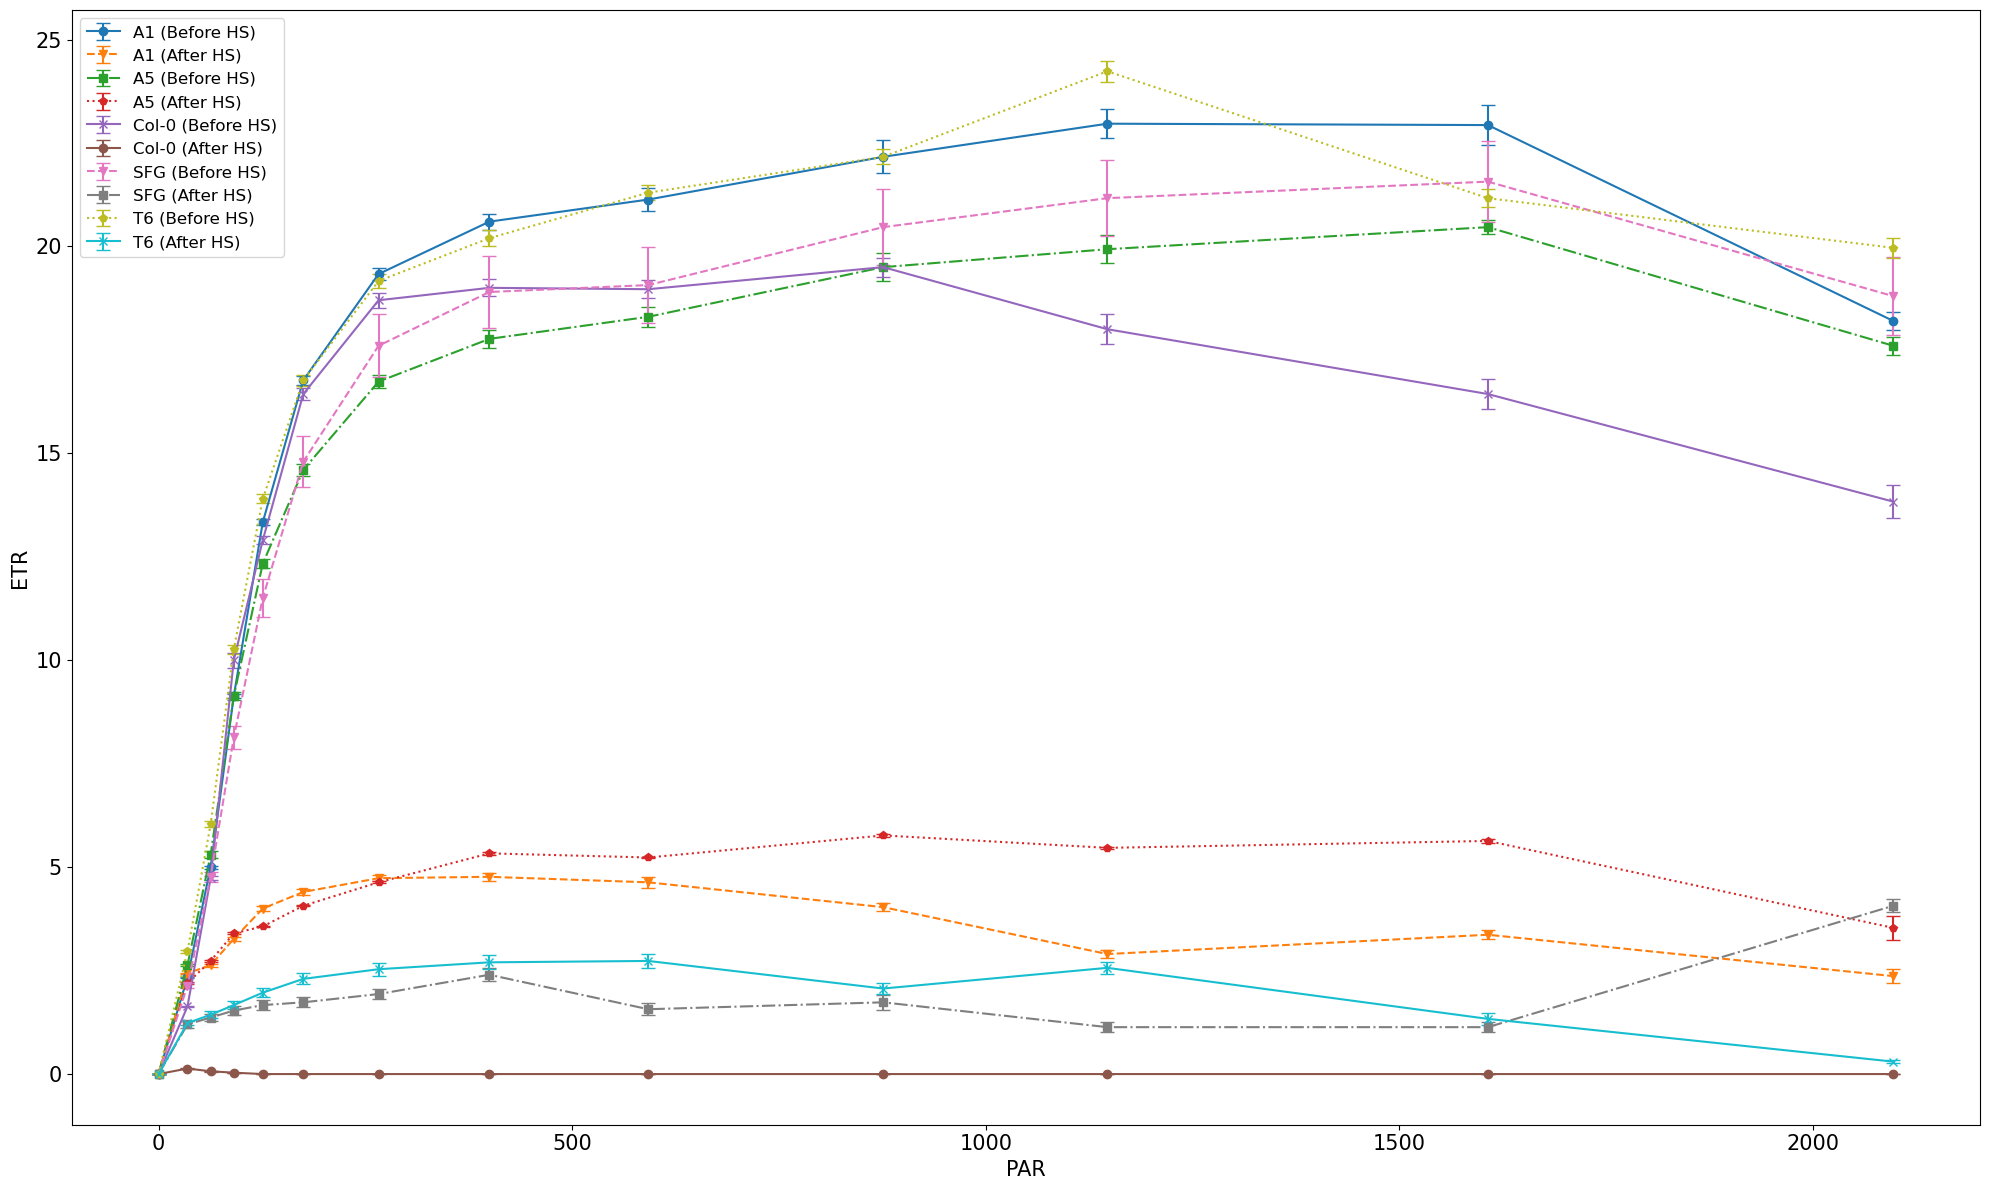

In [221]:
plot_curves(df, 'ETR')

#### Plot the Fv/Fm and do all the statistics

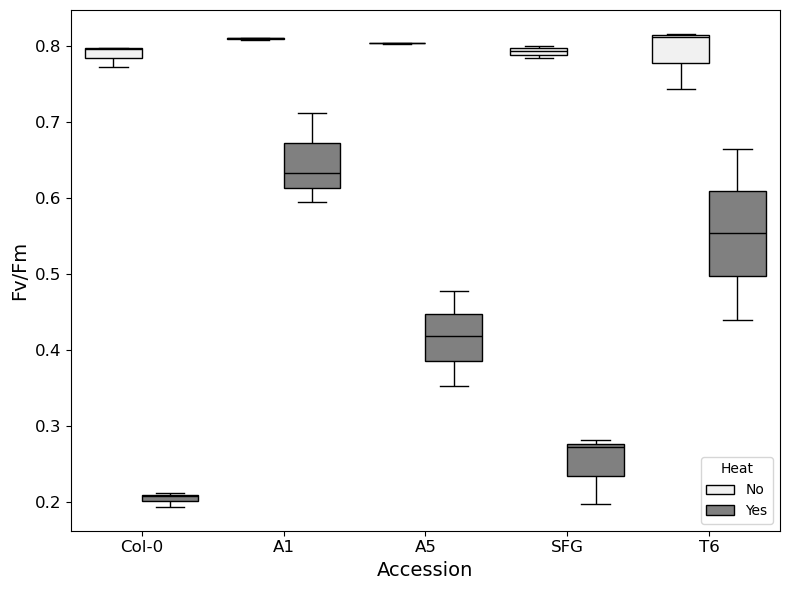

In [359]:
df_QY = df.pivot_table(index='Rep', columns=['Accession','Heat'], values=['Y (II)'], aggfunc=['first'])
df_FvFm = df_QY.melt(value_name='Y (II)', ignore_index=False).reset_index()
df_FvFm = df_FvFm.drop(df_FvFm.columns[:3], axis=1)
df_FvFm = df_FvFm.rename(columns={'variable_2': 'Accession', 'variable_3': 'Heat'})
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_FvFm['Accession'], 
            y=df_FvFm['Y (II)'], 
            hue=df_FvFm['Heat'], 
            data=df_FvFm, 
            linewidth=1,
            fill=True,
            palette='light:grey',
            order= ['Col-0', 'A1','A5','SFG','T6'],
            linecolor = 'black')
plt.ylabel('Fv/Fm', fontsize =  14)
plt.xlabel('Accession',fontsize =  14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [403]:
def letters(df,  Parameter, alpha=0.05):
    results = {}
    
    df['p-adj'] = df['p-adj'].astype(float)
    heat_groups = df['Heat'].unique()
    for heat in df['Heat'].unique():
        sub_df = df[df['Heat'] == heat]

        group1 = set(sub_df.group1.tolist())
        group2 = set(sub_df.group2.tolist())
        groupSet = group1 | group2
        groups = list(groupSet)

        letters_list = list(string.ascii_lowercase)[:len(groups)]
        cldgroups = letters_list.copy()

        cld = pd.DataFrame(list(zip(groups, letters_list, cldgroups)))
        cld[3] = ""

        for row in sub_df.itertuples():
            idx = row.Index
            if sub_df["p-adj"][idx] > alpha:
                cld.iat[groups.index(sub_df["group1"][idx]), 2] += cld.iat[groups.index(sub_df["group2"][idx]), 1]
                cld.iat[groups.index(sub_df["group2"][idx]), 2] += cld.iat[groups.index(sub_df["group1"][idx]), 1]
            else:
                cld.iat[groups.index(sub_df["group1"][idx]), 3] += cld.iat[groups.index(sub_df["group2"][idx]), 1]
                cld.iat[groups.index(sub_df["group2"][idx]), 3] += cld.iat[groups.index(sub_df["group1"][idx]), 1]

        cld[2] = cld[2].apply(lambda x: "".join(sorted(x)))
        cld[3] = cld[3].apply(lambda x: "".join(sorted(x)))
        cld.rename(columns={0: "groups"}, inplace=True)
        cld = cld.sort_values(cld.columns[2], key=lambda x: x.str.len())

        cld["labels"] = ""
        letters_seq = list(string.ascii_lowercase)
        unique = []

        for item in cld[2]:
            for fitem in cld["labels"].unique():
                for c in range(len(fitem)):
                    if not set(unique).issuperset(set(fitem[c])):
                        unique.append(fitem[c])
            g = len(unique)

            for kitem in cld[1]:
                if kitem in item:
                    if cld.loc[cld[1] == kitem, "labels"].iloc[0] == "":
                        cld.loc[cld[1] == kitem, "labels"] += letters_seq[g]

                    if kitem in ' '.join(cld[3][cld["labels"] == letters_seq[g]]):
                        g = len(unique) + 1

                    if len(set(cld.loc[cld[1] == kitem, "labels"].iloc[0])
                               .intersection(cld.loc[cld[2] == item, "labels"].iloc[0])) <= 0:
                        if letters_seq[g] not in cld.loc[cld[1] == kitem, "labels"].iloc[0]:
                                cld.loc[cld[1] == kitem, "labels"] += letters_seq[g]
                        if letters_seq[g] not in cld.loc[cld[2] == item, "labels"].iloc[0]:
                                cld.loc[cld[2] == item, "labels"] += letters_seq[g]

        cld = cld.sort_values("labels")
        cld.drop(columns=[1, 2, 3], inplace=True)
        label_dict = dict(zip(cld["groups"], cld["labels"]))
        results[(heat)] = label_dict
    letters = pd.DataFrame(results)
    with pd.ExcelWriter(path_3, engine='openpyxl', mode='a',if_sheet_exists='replace') as writer:
        letters.to_excel(writer, sheet_name= f'{Parameter} accession')
        
    return results

#### Here I need to calculate one-way ANOVA two times (as in the other results) first time comparing the Accessions at each Heat treatment, second comparing the heat treatments for each Accession (the salinity here is not a variable since ETR were measured only for salt 50 mM)

In [405]:
results_acc = []
posthoc_results_acc = []
for heat in heat_groups:
    subset = df_FvFm[df_FvFm['Heat'] == heat].dropna()
    groups = subset['Accession'].unique()
    anova_data = [subset[subset['Accession'] == group]['Y (II)']
                  for group in groups]
    result = stats.f_oneway(*anova_data)
    results_acc.append({
        'Heat': heat,
        'F-statistic': round(result.statistic, 3),
        'p-value': round(result.pvalue, 4)
    })
    tukey = pairwise_tukeyhsd(endog=subset['Y (II)'],
                              groups=subset['Accession'],
                              alpha=0.05)
    tukey_df = pd.DataFrame(data=tukey.summary().data[1:],
                            columns=tukey.summary().data[0])
    tukey_df['Heat'] = heat
    posthoc_results_acc.append(tukey_df)
acc_table = pd.DataFrame(results_acc)
posthoc_table = pd.concat(posthoc_results_acc, ignore_index=True)
with pd.ExcelWriter(path_1, engine='openpyxl', mode='a',if_sheet_exists='replace') as writer:
    acc_table.to_excel(writer, sheet_name='FvFm accessions', index=False)
with pd.ExcelWriter(path_2, engine='openpyxl', mode='a',if_sheet_exists='replace') as writer:
    posthoc_table.to_excel(writer, sheet_name='FvFm accessions', index=False)

letters(posthoc_table,'FvFm', alpha=0.05)

{'No': {'Col-0': 'a', 'T6': 'a', 'A1': 'a', 'A5': 'a', 'SFG': 'a'},
 'Yes': {'Col-0': 'a', 'SFG': 'ad', 'A1': 'b', 'T6': 'bc', 'A5': 'cd'}}

In [407]:
def letters_acc(df,  Parameter, alpha=0.05):
    results = {}
    
    df['p-adj'] = df['p-adj'].astype(float)
    acc_groups = df['Accession'].unique()
    for acc in df['Accession'].unique():
        sub_df = df[df['Accession'] == acc]

        group1 = set(sub_df.group1.tolist())
        group2 = set(sub_df.group2.tolist())
        groupSet = group1 | group2
        groups = list(groupSet)

        letters_list = list(string.ascii_lowercase)[:len(groups)]
        cldgroups = letters_list.copy()

        cld = pd.DataFrame(list(zip(groups, letters_list, cldgroups)))
        cld[3] = ""

        for row in sub_df.itertuples():
            idx = row.Index
            if sub_df["p-adj"][idx] > alpha:
                cld.iat[groups.index(sub_df["group1"][idx]), 2] += cld.iat[groups.index(sub_df["group2"][idx]), 1]
                cld.iat[groups.index(sub_df["group2"][idx]), 2] += cld.iat[groups.index(sub_df["group1"][idx]), 1]
            else:
                cld.iat[groups.index(sub_df["group1"][idx]), 3] += cld.iat[groups.index(sub_df["group2"][idx]), 1]
                cld.iat[groups.index(sub_df["group2"][idx]), 3] += cld.iat[groups.index(sub_df["group1"][idx]), 1]

        cld[2] = cld[2].apply(lambda x: "".join(sorted(x)))
        cld[3] = cld[3].apply(lambda x: "".join(sorted(x)))
        cld.rename(columns={0: "groups"}, inplace=True)
        cld = cld.sort_values(cld.columns[2], key=lambda x: x.str.len())

        cld["labels"] = ""
        letters_seq = list(string.ascii_lowercase)
        unique = []

        for item in cld[2]:
            for fitem in cld["labels"].unique():
                for c in range(len(fitem)):
                    if not set(unique).issuperset(set(fitem[c])):
                        unique.append(fitem[c])
            g = len(unique)

            for kitem in cld[1]:
                if kitem in item:
                    if cld.loc[cld[1] == kitem, "labels"].iloc[0] == "":
                        cld.loc[cld[1] == kitem, "labels"] += letters_seq[g]

                    if kitem in ' '.join(cld[3][cld["labels"] == letters_seq[g]]):
                        g = len(unique) + 1

                    if len(set(cld.loc[cld[1] == kitem, "labels"].iloc[0])
                               .intersection(cld.loc[cld[2] == item, "labels"].iloc[0])) <= 0:
                        if letters_seq[g] not in cld.loc[cld[1] == kitem, "labels"].iloc[0]:
                                cld.loc[cld[1] == kitem, "labels"] += letters_seq[g]
                        if letters_seq[g] not in cld.loc[cld[2] == item, "labels"].iloc[0]:
                                cld.loc[cld[2] == item, "labels"] += letters_seq[g]

        cld = cld.sort_values("labels")
        cld.drop(columns=[1, 2, 3], inplace=True)
        label_dict = dict(zip(cld["groups"], cld["labels"]))
        results[(acc)] = label_dict
    letters = pd.DataFrame(results)
    with pd.ExcelWriter(path_3, engine='openpyxl', mode='a',if_sheet_exists='replace') as writer:
        letters.to_excel(writer, sheet_name= f'{Parameter} heat')
        
    return results

In [409]:
acc_groups = df_FvFm['Accession'].unique()
results_acc = []
posthoc_results_acc = []
for acc in acc_groups:
    subset = df_FvFm[df_FvFm['Accession'] == acc].dropna()
    heat_groups = subset['Heat'].unique()
    anova_data = [subset[subset['Heat'] == heat]['Y (II)']
                  for heat in heat_groups]
    result = stats.f_oneway(*anova_data)
    results_acc.append({
        'Accession': acc,
        'F-statistic': round(result.statistic, 3),
        'p-value': round(result.pvalue, 4)
    })
    tukey = pairwise_tukeyhsd(endog=subset['Y (II)'],
                              groups=subset['Heat'],
                              alpha=0.05)
    tukey_df = pd.DataFrame(data=tukey.summary().data[1:],
                            columns=tukey.summary().data[0])
    tukey_df['Accession'] = acc
    posthoc_results_acc.append(tukey_df)
acc_table = pd.DataFrame(results_acc)
posthoc_table = pd.concat(posthoc_results_acc, ignore_index=True)
with pd.ExcelWriter(path_1, engine='openpyxl', mode='a',if_sheet_exists='replace') as writer:
    acc_table.to_excel(writer, sheet_name='FvFm heat', index=False)
with pd.ExcelWriter(path_2, engine='openpyxl', mode='a',if_sheet_exists='replace') as writer:
    posthoc_table.to_excel(writer, sheet_name='FvFm heat', index=False)

letters_acc(posthoc_table,'FvFm', alpha=0.05)

{'A1': {'No': 'a', 'Yes': 'b'},
 'A5': {'No': 'a', 'Yes': 'b'},
 'Col-0': {'No': 'a', 'Yes': 'b'},
 'SFG': {'No': 'a', 'Yes': 'b'},
 'T6': {'No': 'a', 'Yes': 'b'}}

#### Plot the ETRmax and do all the statistics

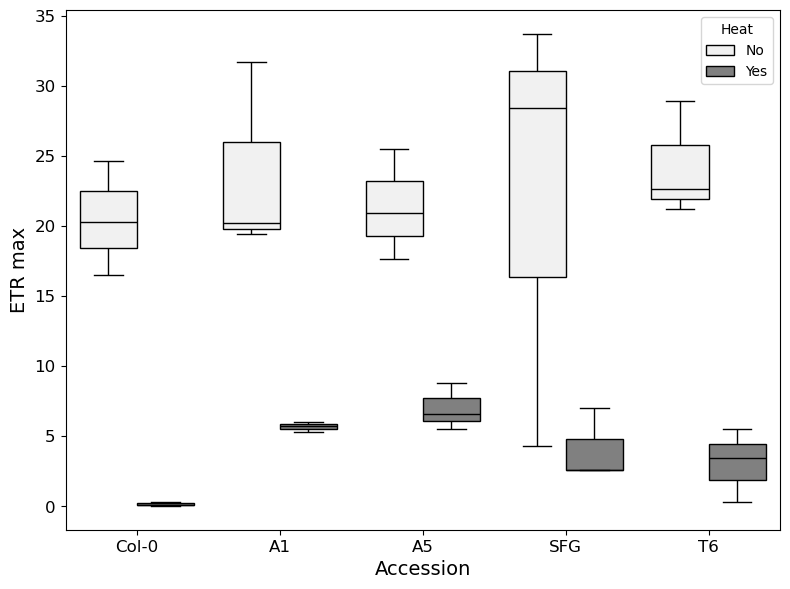

In [9]:
df_ETRmax = df.pivot_table(index='Rep', columns=['Accession','Heat'], values=['ETR'], aggfunc=['max'])
df_melted = df_ETRmax.melt(value_name='ETR', ignore_index=False).reset_index()
df_melted = df_melted.drop(df_melted.columns[:3], axis=1)
df_melted = df_melted.rename(columns={'variable_2': 'Accession', 'variable_3': 'Heat'})
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_melted['Accession'], 
            y=df_melted['ETR'], 
            hue=df_melted['Heat'], 
            data=df_melted, 
            linewidth=1,
            fill=True,
            palette='light:grey',
            order= ['Col-0', 'A1','A5','SFG','T6'],
            linecolor = 'black')
plt.ylabel('ETR max', fontsize =  14)
plt.xlabel('Accession',fontsize =  14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [413]:
results_acc = []
posthoc_results_acc = []
for heat in heat_groups:
    subset = df_melted[df_melted['Heat'] == heat].dropna()
    groups = subset['Accession'].unique()
    anova_data = [subset[subset['Accession'] == group]['ETR']
                  for group in groups]
    result = stats.f_oneway(*anova_data)
    results_acc.append({
        'Heat': heat,
        'F-statistic': round(result.statistic, 3),
        'p-value': round(result.pvalue, 4)
    })
    tukey = pairwise_tukeyhsd(endog=subset['ETR'],
                              groups=subset['Accession'],
                              alpha=0.05)
    tukey_df = pd.DataFrame(data=tukey.summary().data[1:],
                            columns=tukey.summary().data[0])
    tukey_df['Heat'] = heat
    posthoc_results_acc.append(tukey_df)
acc_table = pd.DataFrame(results_acc)
posthoc_table = pd.concat(posthoc_results_acc, ignore_index=True)
with pd.ExcelWriter(path_1, engine='openpyxl', mode='a',if_sheet_exists='replace') as writer:
    acc_table.to_excel(writer, sheet_name='ETRmax accessions', index=False)
with pd.ExcelWriter(path_2, engine='openpyxl', mode='a',if_sheet_exists='replace') as writer:
    posthoc_table.to_excel(writer, sheet_name='ETRmax accessions', index=False)

letters(posthoc_table,'ETR', alpha=0.05)

{'No': {'Col-0': 'a', 'T6': 'a', 'A1': 'a', 'A5': 'a', 'SFG': 'a'},
 'Yes': {'Col-0': 'a', 'T6': 'ab', 'SFG': 'ab', 'A1': 'b', 'A5': 'b'}}

In [346]:
acc_groups = df_melted['Accession'].unique()
results_acc = []
posthoc_results_acc = []
for acc in acc_groups:
    subset = df_melted[df_melted['Accession'] == acc].dropna()
    heat_groups = subset['Heat'].unique()
    anova_data = [subset[subset['Heat'] == heat]['ETR']
                  for heat in heat_groups]
    result = stats.f_oneway(*anova_data)
    results_acc.append({
        'Accession': acc,
        'F-statistic': round(result.statistic, 3),
        'p-value': round(result.pvalue, 4)
    })
    tukey = pairwise_tukeyhsd(endog=subset['ETR'],
                              groups=subset['Heat'],
                              alpha=0.05)
    tukey_df = pd.DataFrame(data=tukey.summary().data[1:],
                            columns=tukey.summary().data[0])
    tukey_df['Accession'] = acc
    posthoc_results_acc.append(tukey_df)
acc_table = pd.DataFrame(results_acc)
posthoc_table = pd.concat(posthoc_results_acc, ignore_index=True)
with pd.ExcelWriter(path_1, engine='openpyxl', mode='a',if_sheet_exists='replace') as writer:
    acc_table.to_excel(writer, sheet_name='ETR heat', index=False)
with pd.ExcelWriter(path_2, engine='openpyxl', mode='a',if_sheet_exists='replace') as writer:
    posthoc_table.to_excel(writer, sheet_name='ETR heat', index=False)

## Screening results

In [51]:
df_sn = pd.read_excel('Arabidopsis Ecotypes.xlsx', sheet_name = 'Screening_table')
df_sn.head()

,Accession,Lab/field,WHITE,LIGHT GREEN,GOOD,Germinated seeds,Germination rate,Coast/inland
0,A1,Field,0.400000,0.400000,0.200000,10,0.333333,NaN
1,A1,Lab,0.066667,0.566667,0.366667,30,1.000000,NaN
2,A5,Lab,0.966667,0.000000,0.033333,30,1.000000,NaN
3,A5,Field,0.000000,0.833333,0.166667,6,0.200000,NaN
4,AM,Lab,0.105263,0.684211,0.210526,19,0.633333,NaN


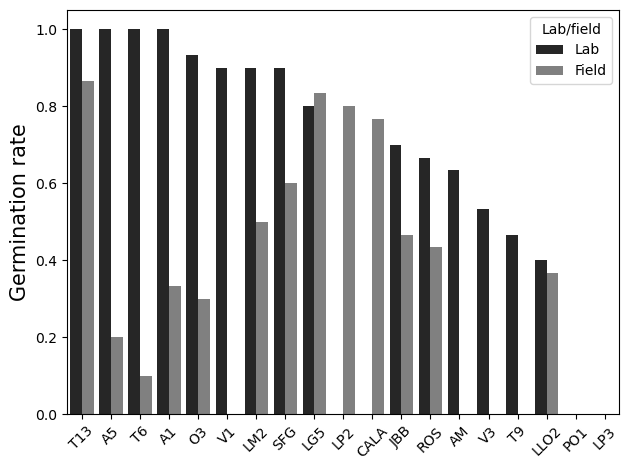

In [77]:
df_sorted = df_sn.sort_values(by='Germination rate', ascending=False)
sns.barplot(data=df_sorted, x='Accession', y='Germination rate', hue='Lab/field', palette='dark:grey')
plt.ylabel('Germination rate',fontsize = 15)
plt.xlabel('')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [39]:
df_melted = df_sn.melt(id_vars=['Accession'], 
                    value_vars=['WHITE', 'LIGHT GREEN', 'GOOD'],
                    var_name='Category', 
                    value_name='Value')
df_melted

,Accession,Category,Value
0,A5,WHITE,0.966667
1,A5,WHITE,0.000000
2,T6,WHITE,0.866667
3,T6,WHITE,0.000000
4,JBB,WHITE,0.000000
...,...,...,...
82,O3,GOOD,0.214286
83,V3,GOOD,0.125000
84,T9,GOOD,0.071429
85,CALA,GOOD,0.130435


In [41]:
pivot = df_melted.pivot_table(index=['Accession'], 
                               columns='Category', 
                               values='Value', aggfunc='mean')
pivot

Category,GOOD,LIGHT GREEN,WHITE
Accession,,,
A1,0.283333,0.483333,0.233333
A5,0.100000,0.416667,0.483333
AM,0.210526,0.684211,0.105263
CALA,0.130435,0.521739,0.347826
JBB,0.250000,0.392857,0.357143
LG5,0.083333,0.729167,0.187500
LLO2,0.090909,0.575758,0.333333
LM2,0.155556,0.540741,0.303704
LP2,0.083333,0.583333,0.333333


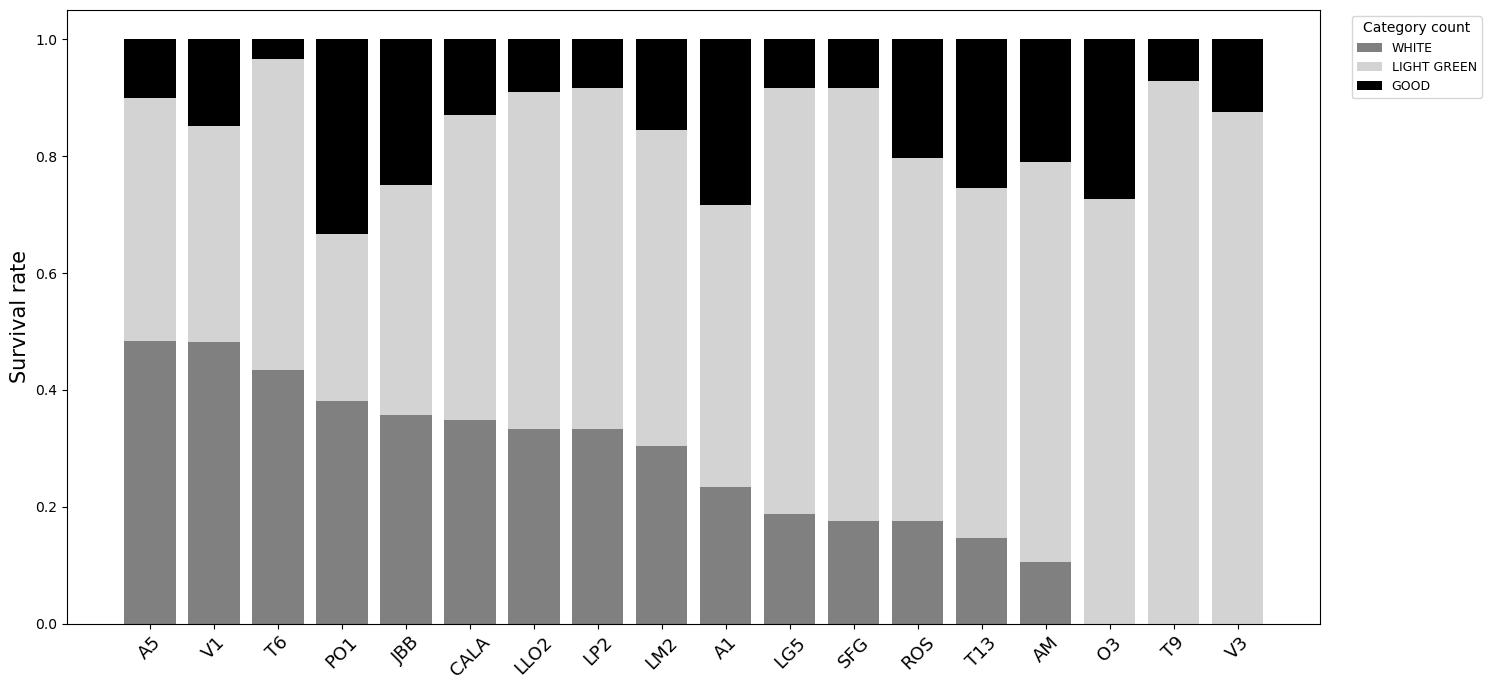

In [81]:
pivot_sorted = pivot.sort_values(by='WHITE', ascending=False)

fig, ax = plt.subplots(figsize=(15, 7))

labels = [f"{a}" for a in pivot_sorted.index]

bottom = None
colors = {'WHITE': 'grey', 'LIGHT GREEN': 'lightgrey', 'GOOD': 'black'}

for category in ['WHITE', 'LIGHT GREEN', 'GOOD']:
    values = pivot_sorted[category]
    ax.bar(labels, values, bottom=bottom, label=category, color=colors[category])
    if bottom is None:
        bottom = values
    else:
        bottom += values

ax.set_ylabel('Survival rate',fontsize = 15)
ax.set_title('')
ax.legend(title='Category count',bbox_to_anchor=(1.02, 1), loc='upper left',fontsize = 9)
plt.xticks(rotation=45, fontsize = 13)
plt.tight_layout()
plt.show()

### It should be all :)